# Chapter 5: Image Feature Extraction and its Applications: Image Registration

## Problems
  1. Corner Detectors with `opencv-python`:  
     1.1 Harris Corner Detector     
     1.2 Shi-Tomasi Corner Detector     
  2. Image Regustration (Matching)  
     2.1 with ORB features using `opencv-python`   
     2.2 with ORB features using `scikit-image`   
     2.3 with SURF features with `opencv-python`     
     2.4 with DISK features with `kornia`
  3. Image Color Channel Alignment using Image Registration with `pystackreg`     
  4. Deformable Image Registration with `pyelastix`
  5. Image Registration with `SimpleITK`  
     5.1 with B-Splines     
     5.2 with Demons     
  6. Deep Deformable Image Registration with *VoxelMorph* with `tensorflow` / `keras`

## 1. Corner Detectors with `opencv-python`

## 1.1 Harris Corner Detector

In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pylab as plt

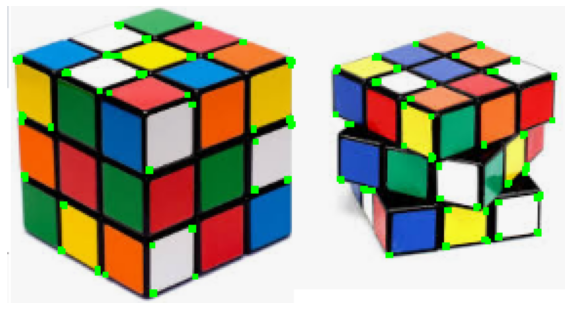

In [5]:
orig_img = cv2.imread('images/Img_07_01.png')
img = orig_img.copy()
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
# dilate to mark the corners
dst = cv2.dilate(dst,None)
# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.075*dst.max()]=[0,255,0]
plt.figure(figsize=(10,8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.axis('off')
plt.show()

### Corner with SubPixel Accuracy

* The function `cv2.cornerSubPix()` further refines the corners detected with sub-pixel accuracy. Let' demonstrate it using the next code snippet. 
* As usual, we need to find the Harris corners first. Then we need to pass the centroids of these corners to refine them. 
* Harris corners are marked in red pixels and refined corners are marked in green pixels. 
* For this function, we have to define the criteria when to stop the iteration. We stop it after a specified number of iterations or a certain accuracy is achieved, whichever occurs first. 
* We also need to define the size of the neighbourhood it searches for corners (e.g., $5 \times 5$ nbd), as shown in the next code snippet.

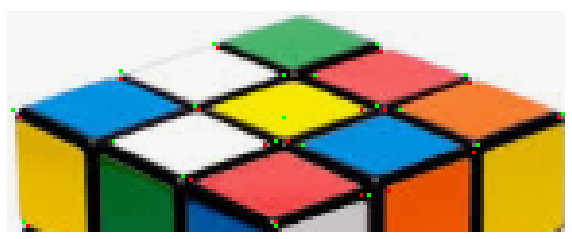

In [27]:
# find Harris corners
orig_img = cv2.imread('images/rcube_cropped.png')
img = orig_img.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
dst = cv2.cornerHarris(gray,2,3,0.04)
dst = cv2.dilate(dst, None)
ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
dst = np.uint8(dst)
# find centroids
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
# define the criteria to stop and refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
# Now draw them
res = np.hstack((centroids,corners))
res = np.int0(res)
img[res[:,1],res[:,0]]=[0,0,255]
img[np.minimum(res[:,3],img.shape[0]-1),np.minimum(res[:,2], img.shape[1]-1)] = [0,255,0]
plt.figure(figsize=(10,8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.axis('off')
plt.show()

## 1.2 Shi-Tomasi Corner Detector

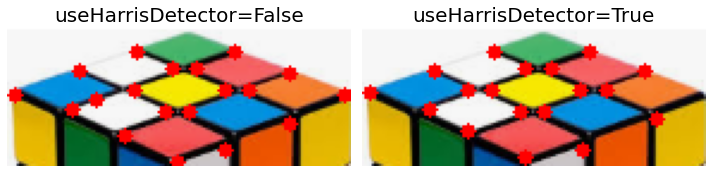

In [29]:
plt.figure(figsize=(10,8))

for useHarrisDetector in [True, False]:
    img = orig_img.copy()
    corners = cv2.goodFeaturesToTrack(gray,25,0.01,10, useHarrisDetector = useHarrisDetector)
    corners = np.int0(corners)
    for i in corners:
        x,y = i.ravel()
        cv2.circle(img,(x,y),3,(0,0,255),-1)
    plt.subplot(1,2,useHarrisDetector+1), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.axis('off')
    plt.title(f'useHarrisDetector={useHarrisDetector}', size=20)

plt.tight_layout()
plt.show()

## 2. Image Alignment / Matching - Image Registration

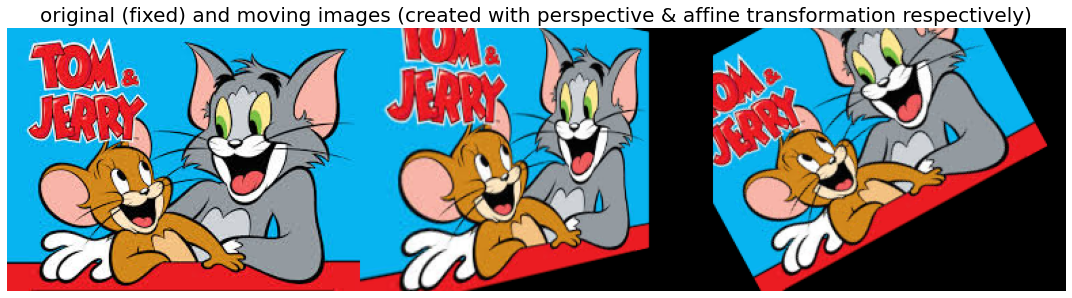

In [42]:
im1 = plt.imread('images/Img_07_07.jpg')
# slope of the perspective transform
h, w, _ = im.shape
slope = np.tan(np.radians(30))
perspective_matrix = np.linalg.inv(np.array([[1, 0, 0],
                        [-slope/3, 1, slope * h / 3],
                        [-slope/w, 0, 1 + slope/2]]))
im2 = cv2.warpPerspective(im, perspective_matrix, (w,h))
plt.imsave('images/Img_07_08.jpg', im2)

rot = np.array([[np.cos(0.5), -np.sin(0.5), 0],[np.sin(0.5), np.cos(0.5), 0], [0,0,1]])
tr = np.array([[1,0, 50],[0, 1, -50], [0,0,1]])
sc = np.array([[1.1,0, 0],[0, 1.1, 0], [0,0,1]])
affine_mat = np.linalg.inv(rot @ tr @ sc)
im3 = cv2.warpAffine(im, affine_mat[:2,:], (w,h))
plt.imsave('images/Img_07_09.jpg', im3)

plt.figure(figsize=(15,7))
plt.imshow(np.hstack((im1, im2, im3))), plt.axis('off')
plt.title('original (fixed) and moving images (created with perspective & affine transformation respectively)', size=20)
plt.tight_layout()
plt.show()

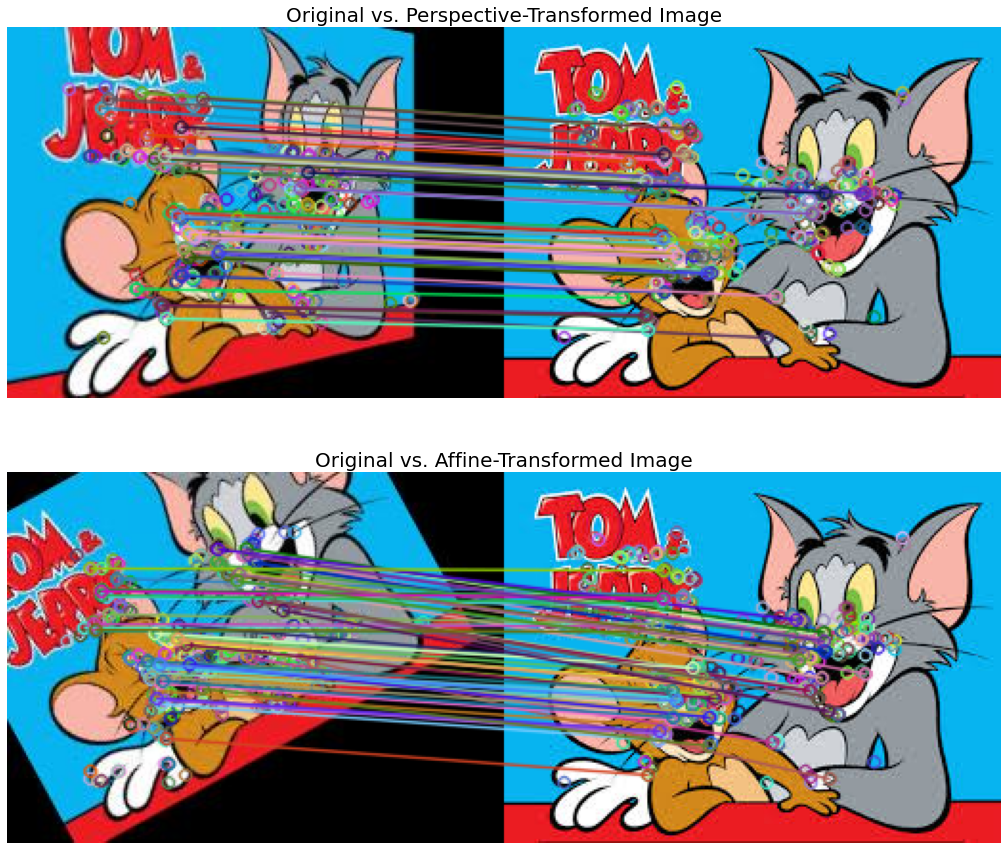


 Estimated homography : 
 [[ 8.21788026e-01  1.61971819e-03 -2.40068712e+00]
 [-1.34251105e-01  8.00578888e-01  2.75024081e+01]
 [-1.52078398e-03  1.31085142e-05  1.00000000e+00]]

 Estimated homography : 
 [[ 9.83624364e-01 -5.34196484e-01  6.76430982e+01]
 [ 5.43767499e-01  9.74305147e-01 -2.11468782e+01]
 [ 1.15192040e-04 -3.90720842e-05  1.00000000e+00]]


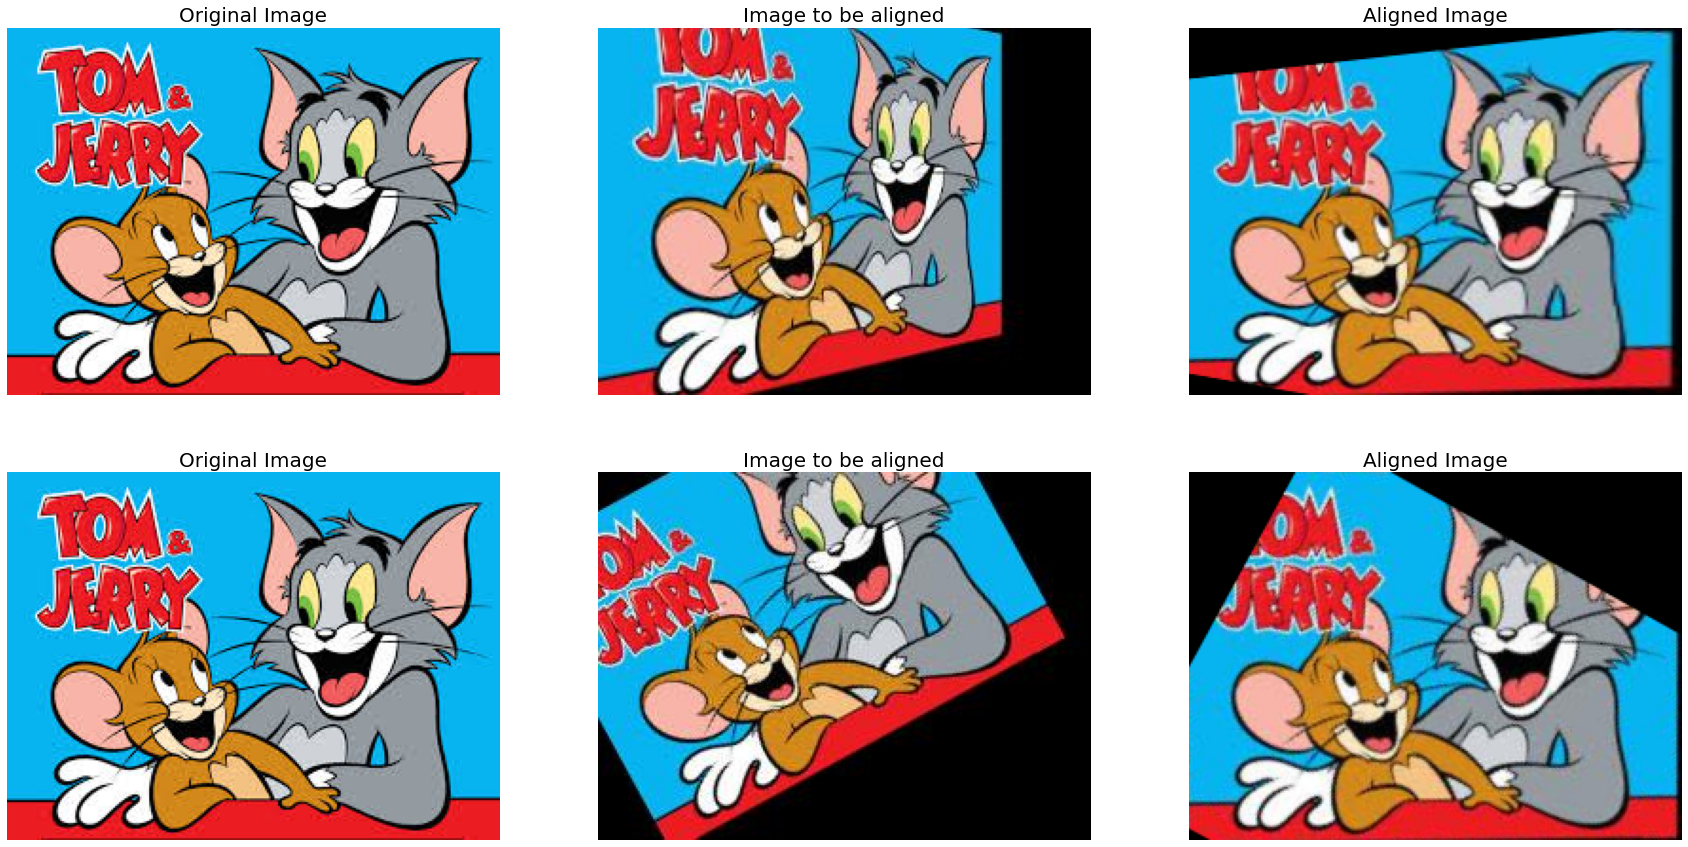

In [43]:
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15

# reference image
im_ref = cv2.imread('images/Img_07_07.jpg') 
# images to be aligned
im1 = cv2.imread('images/Img_07_08.jpg') 
im2 = cv2.imread('images/Img_07_09.jpg') 

# Convert images to grayscale
im_ref_g = cv2.cvtColor(im_ref, cv2.COLOR_RGB2GRAY)
im1_g, im2_g = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY), cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY)

# Detect ORB features and compute descriptors.
orb = cv2.ORB_create(MAX_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(im1_g, None)
keypoints2, descriptors2 = orb.detectAndCompute(im2_g, None)
keypoints_ref, descriptors_ref = orb.detectAndCompute(im_ref_g, None)
   
# Match features.
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
matches1 = matcher.match(descriptors1, descriptors_ref, None)
matches2 = matcher.match(descriptors2, descriptors_ref, None)
   
# Sort matches by score
matches1.sort(key=lambda x: x.distance, reverse=False)
matches2.sort(key=lambda x: x.distance, reverse=False)
# Remove not so good matches
num_good_matches = int(len(matches1) * GOOD_MATCH_PERCENT)
matches1 = matches1[:num_good_matches]
num_good_matches = int(len(matches2) * GOOD_MATCH_PERCENT)
matches2 = matches2[:num_good_matches]
 
# Draw top matches
plt.figure(figsize=(20,15))
im_matches = cv2.drawMatches(im1, keypoints1, im_ref, keypoints_ref, matches1, None)
plt.subplot(211), plt.imshow(cv2.cvtColor(im_matches, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Original vs. Perspective-Transformed Image', size=20)
im_matches = cv2.drawMatches(im2, keypoints2, im_ref, keypoints_ref, matches2, None)
plt.subplot(212), plt.imshow(cv2.cvtColor(im_matches, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Original vs. Affine-Transformed Image', size=20)
plt.show()

def compute_alignment(matches, im, keypoints, keypoints_ref):
    # Extract location of good matches
    points = np.zeros((len(matches), 2), dtype=np.float32)
    points_ref = np.zeros((len(matches), 2), dtype=np.float32) 
    for i, match in enumerate(matches):
        points[i, :] = keypoints[match.queryIdx].pt
        points_ref[i, :] = keypoints_ref[match.trainIdx].pt   
    # Find homography
    h, mask = cv2.findHomography(points, points_ref, cv2.RANSAC)
    # Use homography
    height, width, channels = im.shape
    im_ref_reg = cv2.warpPerspective(im, h, (width, height))
    # Print estimated homography
    print("\n Estimated homography : \n",  h)
    return im_ref_reg

im1_reg = compute_alignment(matches1, im1, keypoints1, keypoints_ref)
im2_reg = compute_alignment(matches2, im2, keypoints2, keypoints_ref)

plt.figure(figsize=(30,15))
plt.subplot(231), plt.imshow(cv2.cvtColor(im_ref, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Original Image', size=20)
plt.subplot(232), plt.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Image to be aligned', size=20)
plt.subplot(233), plt.imshow(cv2.cvtColor(im1_reg, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Aligned Image', size=20)
plt.subplot(234), plt.imshow(cv2.cvtColor(im_ref, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Original Image', size=20)
plt.subplot(235), plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Image to be aligned', size=20)
plt.subplot(236), plt.imshow(cv2.cvtColor(im2_reg, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Aligned Image', size=20)
plt.show()

## 2.2 with ORB features using `scikit-image`

Now let's demonstrate image matching using the ORB features again, but this time the detection and binary descriptor
computation algorithm implemented using the `feature` module's functions from the library `scikit-image` (e.g., the method `detect_and_extract()` from the class `ORB` and the function `match_descriptors()`, as shown in the next code snippet, most of which is self-explanatory). As compared to BRIEF features, ORB is more scale and rotation invariant, even this applies the Hamming distance metric for matching, which is more efficient. Hence, this method is preferred over BRIEF when considering real-time applications.

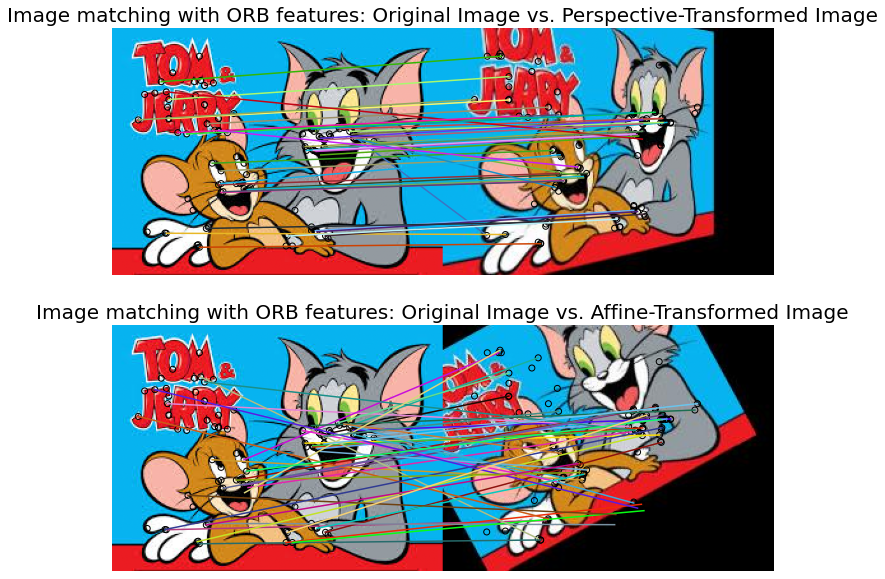

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import (match_descriptors, ORB, plot_matches)
from skimage.io import imread, imsave
from skimage.color import rgb2gray

im1 = imread('images/Img_07_07.jpg')
im2 = imread('images/Img_07_08.jpg') 
im3 = imread('images/Img_07_09.jpg') 

im1_g, im2_g, im3_g = rgb2gray(im1), rgb2gray(im2), rgb2gray(im3)
descriptor_extractor = ORB(n_keypoints=100)
descriptor_extractor.detect_and_extract(im1_g)
keypoints1, descriptors1 = descriptor_extractor.keypoints, descriptor_extractor.descriptors
descriptor_extractor.detect_and_extract(im2_g)
keypoints2, descriptors2 = descriptor_extractor.keypoints, descriptor_extractor.descriptors
matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)
descriptor_extractor.detect_and_extract(im3_g)
keypoints3, descriptors3 = descriptor_extractor.keypoints, descriptor_extractor.descriptors
matches13 = match_descriptors(descriptors1, descriptors3, cross_check=True)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
plt.gray()
plot_matches(axes[0], im1, im2, keypoints1, keypoints2, matches12)
axes[0].axis('off'), axes[0].set_title("Image matching with ORB features: Original Image vs. Perspective-Transformed Image", size=20)
plot_matches(axes[1], im1, im3, keypoints1, keypoints2, matches13)
axes[1].axis('off'), axes[1].set_title("Image matching with ORB features: Original Image vs. Affine-Transformed Image", size=20)
plt.show()

## 2.3 with SURF features with `opencv-python`

3.4.2


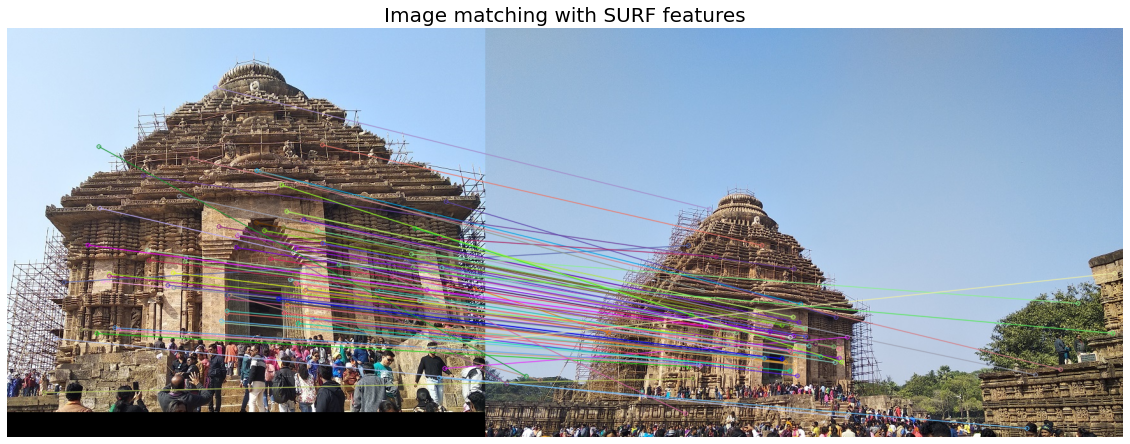

In [1]:
import numpy as np
# pip install opencv-python==3.4.2.17 opencv-contrib-python==3.4.2.17
# https://stackoverflow.com/questions/37039224/attributeerror-module-object-has-no-attribute-xfeatures2d-python-opencv-2
import cv2
print(cv2.__version__)

from matplotlib import pyplot as plt

img1 = cv2.imread('images/Img_07_05.jpg') # queryImage
img2 = cv2.imread('images/Img_07_06.jpg') # trainImage

img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Create a SURF detector object
#sift = cv2.xfeatures2d.SIFT_create()
surf = cv2.xfeatures2d.SURF_create(400)

# find the keypoints and descriptors with SURF
kp1, des1 = surf.detectAndCompute(img1_gray,None)
kp2, des2 = surf.detectAndCompute(img2_gray,None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=2)

plt.figure(figsize=(20,10)), plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)), plt.axis('off')
plt.title('Image matching with SURF features', size=20)
plt.show()

### 2.4 with DISK features with `kornia`

In [ ]:
# run in colab
#!pip install kornia
# !pip install kornia_moons --no-deps
import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import numpy as np
import torch
from kornia.feature.adalam import AdalamFilter
from kornia_moons.viz import *

device = K.utils.get_cuda_or_mps_device_if_available()
print(device)
# cuda:0

In [ ]:
img1 = K.io.load_image("images/Img_07_07.jpg", K.io.ImageLoadType.RGB32, device=device)[None, ...]
img2 = K.io.load_image("images/Img_07_09.jpg", K.io.ImageLoadType.RGB32, device=device)[None, ...]

disk = KF.DISK.from_pretrained("depth").to(device)

hw1 = torch.tensor(img1.shape[2:], device=device)
hw2 = torch.tensor(img2.shape[2:], device=device)

adalam_config = KF.adalam.get_adalam_default_config()
adalam_config["force_seed_mnn"] = False
adalam_config["search_expansion"] = 16
adalam_config["ransac_iters"] = 256

num_features = 2048

with torch.inference_mode():
    inp = torch.cat([img1, img2], dim=0)
    features1, features2 = disk(inp, num_features, pad_if_not_divisible=True)
    kps1, descs1 = features1.keypoints, features1.descriptors
    kps2, descs2 = features2.keypoints, features2.descriptors
    lafs1 = KF.laf_from_center_scale_ori(kps1[None], 96 * torch.ones(1, len(kps1), 1, 1, device=device))
    lafs2 = KF.laf_from_center_scale_ori(kps2[None], 96 * torch.ones(1, len(kps2), 1, 1, device=device))
    dists, idxs = KF.match_adalam(descs1, descs2, lafs1, lafs2, hw1=hw1, hw2=hw2, config=adalam_config)

print(f"{idxs.shape[0]} tentative matches with DISK AdaLAM")
# 198 tentative matches with DISK AdaLAM

In [ ]:
def get_matching_keypoints(kp1, kp2, idxs):
    mkpts1 = kp1[idxs[:, 0]]
    mkpts2 = kp2[idxs[:, 1]]
    return mkpts1, mkpts2

mkpts1, mkpts2 = get_matching_keypoints(kps1, kps2, idxs)

Fm, inliers = cv2.findFundamentalMat(
    mkpts1.detach().cpu().numpy(), mkpts2.detach().cpu().numpy(), cv2.USAC_MAGSAC, 0.5, 0.999, 100000 # 1.0
)
inliers = inliers > 0
print(f"{inliers.sum()} inliers with DISK")
# 71 inliers with DISK

In [ ]:
draw_LAF_matches(
    KF.laf_from_center_scale_ori(kps1[None].cpu()),
    KF.laf_from_center_scale_ori(kps2[None].cpu()),
    idxs.cpu(),
    K.tensor_to_image(img1.cpu()),
    K.tensor_to_image(img2.cpu()),
    inliers,
    draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": (1, 1, 0.2, 0.3), "feature_color": None, "vertical": False},
)

![](images/kornia_out.png)

## 3. Image Color Channel Alignment using Image Registration with `pystackreg`

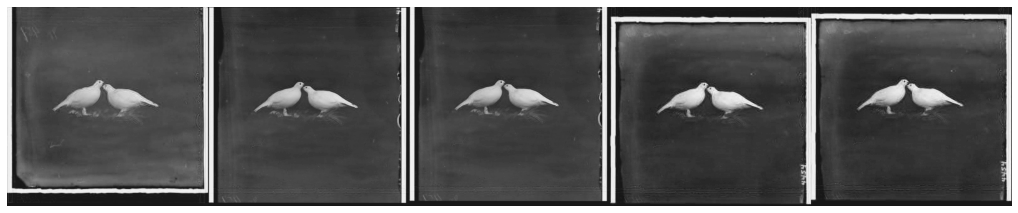

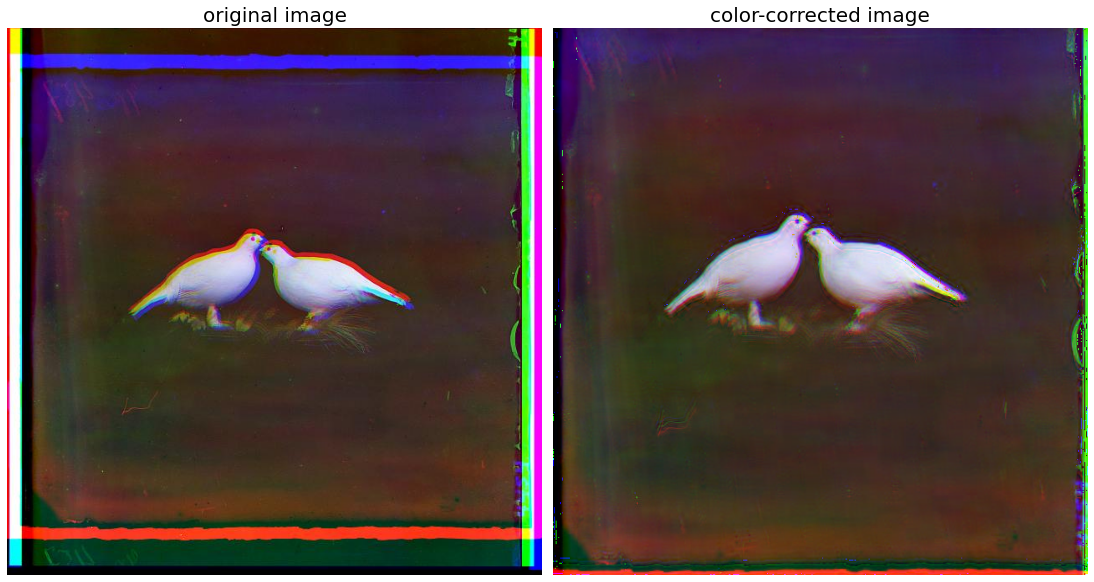

In [51]:
# ! pip install pystackreg
from pystackreg import StackReg
from skimage import io
from skimage.util import crop

#im = io.imread('images/emir.jpg')
im = io.imread('images/birds.jpg')
r, g, b = im[...,0], im[...,1], im[...,2]

#load reference and "moved" image
#Translational transformation
sr = StackReg(StackReg.TRANSLATION)
g_ = sr.register_transform(r, g)
b_ = sr.register_transform(r, b)

im_rec = im.copy()
im_rec[...,1], im_rec[...,2] = g_, b_

im_rec = crop(im_rec, ((50, 50), (20, 20), (0,0)), copy=False)
plt.figure(figsize=(18,7))
plt.gray()
plt.imshow(np.hstack((r, g, g_, b, b_))), plt.axis('off')
plt.show()
plt.figure(figsize=(15,8))
plt.subplots_adjust(0,0,1,0.95,0.02,0.02)
plt.subplot(121), plt.imshow(im, aspect='auto'), plt.axis('off'), plt.title('original image', size=20)
plt.subplot(122), plt.imshow(im_rec, aspect='auto'), plt.axis('off'), plt.title('color-corrected image', size=20)
plt.show()

The above figure shows the original image with color-channel misalignment, the registered channels and the cropped color-
channel-registered output image, as can be seen the color channels are much better aligned now, the output image looks much less blurry that the original input.

## 4. Deformable Image Registration with pyelastix

<10 parameters>
                             Metric: 'AdvancedMattesMutualInformation'
              NumberOfHistogramBins: 32
                       ImageSampler: 'RandomCoordinate'
             NumberOfSpatialSamples: 2048
           NewSamplesEveryIteration: True
                NumberOfResolutions: 3
                          Transform: 'BSplineTransform'
    FinalGridSpacingInPhysicalUnits: 16
                          Optimizer: 'AdaptiveStochasticGradientDescent'
          MaximumNumberOfIterations: 500

Found elastix version: 4.900 in 'elastix.exe'


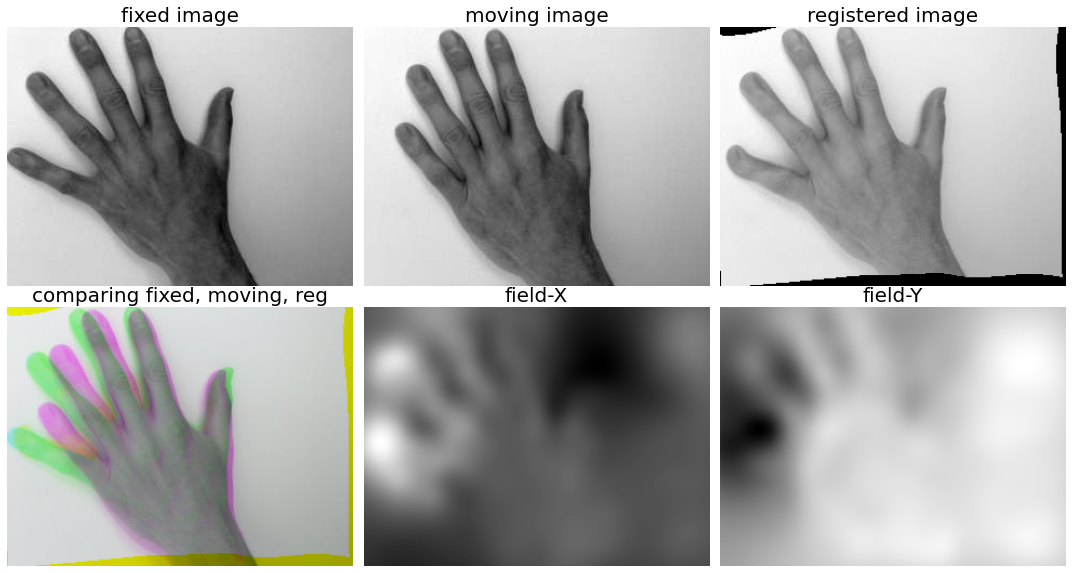

In [116]:
# ! pip install pyelastix
import pyelastix
import os
from skimage.color import rgb2gray
import imageio
import numpy as np
import matplotlib.pylab as plt

os.environ["PATH"] += os.pathsep + 'elastix-5.1.0-win64'

im_fixed = imageio.imread('images/hands1.jpg')
im_moving = imageio.imread('images/hands2.jpg')

im_fixed, im_moving = rgb2gray(im_fixed), rgb2gray(im_moving)

# Get default params and adjust
params = pyelastix.get_default_params()
params.NumberOfResolutions = 3
print(params)

# Register!
im_reg, field = pyelastix.register(im_moving, im_fixed, params, verbose=0)

# Visualize the result
fig = plt.figure(figsize=(15,8));
plt.gray()
plt.clf()
plt.subplot(231); plt.imshow(im_fixed), plt.axis('off'), plt.title('fixed image', size=20)
plt.subplot(232); plt.imshow(im_moving), plt.axis('off'), plt.title('moving image', size=20)
plt.subplot(233); plt.imshow(im_reg), plt.axis('off'), plt.title('registered image', size=20)
plt.subplot(234); plt.imshow(np.dstack((im_fixed, im_moving, im_reg))), plt.axis('off'), plt.title('comparing fixed, moving, reg', size=20)
plt.subplot(235); plt.imshow(field[0]), plt.axis('off'), plt.title('field-X', size=20)
plt.subplot(236); plt.imshow(field[1]), plt.axis('off'), plt.title('field-Y', size=20)
plt.tight_layout()
plt.show()

## 5. Image Registration with `SimpleITK`

## 5.1 with B-Splines

Initial Number of Parameters: 50


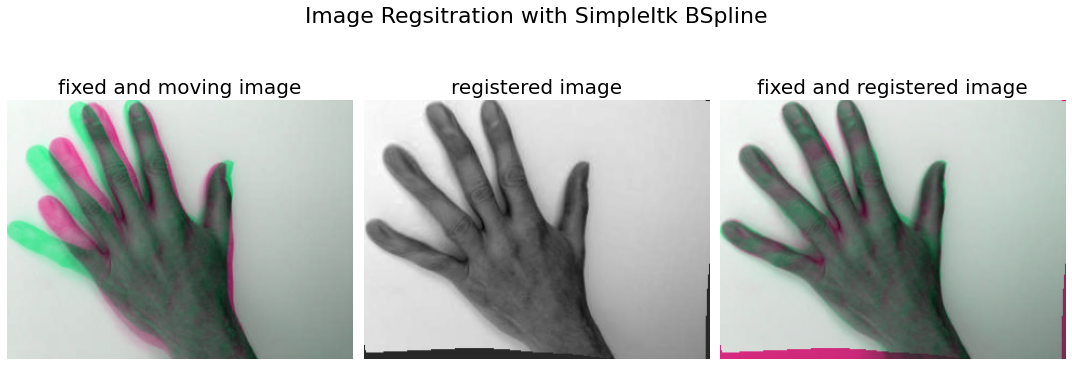

In [115]:
import SimpleITK as sitk
import sys
import os

fixed = sitk.ReadImage('images/hands1.jpg', sitk.sitkFloat32)
moving = sitk.ReadImage('images/hands2.jpg', sitk.sitkFloat32)

transform_domain_mesh_size = [2] * fixed.GetDimension()
tx = sitk.BSplineTransformInitializer(fixed, transform_domain_mesh_size)

print(f"Initial Number of Parameters: {tx.GetNumberOfParameters()}")

registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsJointHistogramMutualInformation()
registration_method.SetOptimizerAsGradientDescentLineSearch(5.0, 100, convergenceMinimumValue=1e-4, convergenceWindowSize=5)
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetInitialTransformAsBSpline(tx, inPlace=True, scaleFactors=[1, 2, 5])
registration_method.SetShrinkFactorsPerLevel([4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel([4, 2, 1])

outTx = registration_method.Execute(fixed, moving)

resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(100)
resampler.SetTransform(outTx)

out = resampler.Execute(moving)

simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
simg2 = sitk.Cast(sitk.RescaleIntensity(moving), sitk.sitkUInt8)
simg3 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)

# Visualize the result
fig = plt.figure(figsize=(15,6));
plt.gray()
plt.clf()
plt.subplot(131); plt.imshow(sitk.GetArrayFromImage(sitk.Compose(simg1, simg2, simg1 // 2.0 + simg2 // 2.0)))
plt.axis('off'), plt.title('fixed and moving image', size=20)
plt.subplot(132); plt.imshow(sitk.GetArrayFromImage(out)), plt.axis('off'), plt.title('registered image', size=20)
plt.subplot(133); plt.imshow(sitk.GetArrayFromImage(sitk.Compose(simg1, simg3, simg1 // 2.0 + simg3 // 2.0))) 
plt.axis('off'), plt.title('fixed and registered image', size=20)
plt.suptitle('Image Regsitration with SimpleItk BSpline', size=22)
plt.tight_layout()
plt.show()

The above figur shows the moving image overlayed on the fixed image befor and after registration - observe the alignment of the registered image is way better than the initial moving image.

## 5.2 with Demons

Initial Number of Parameters: 50
-------
Number Of Iterations: 200
 RMS: 0.2871094570605489


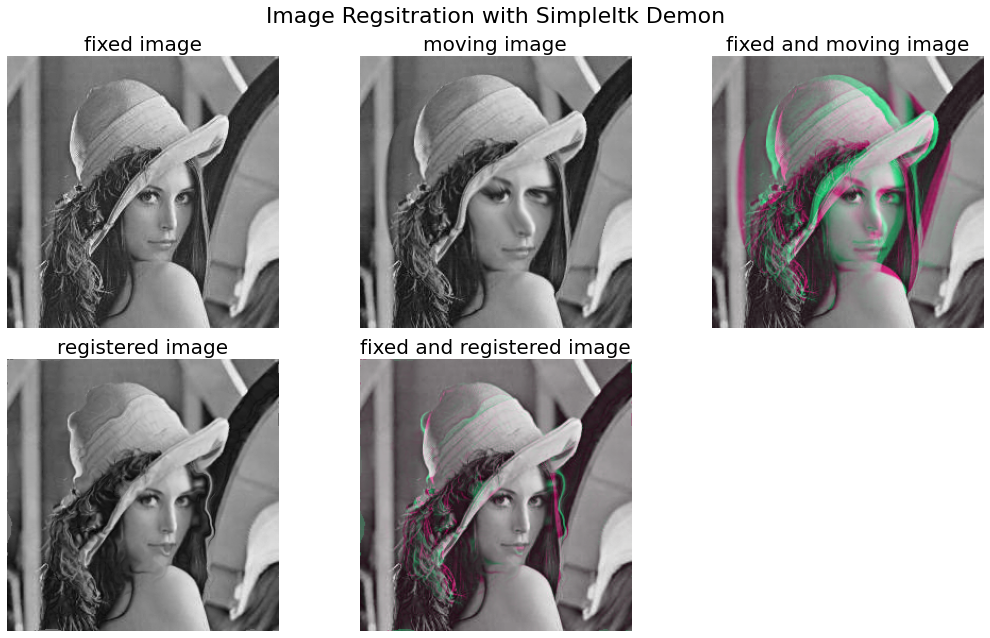

In [33]:
import SimpleITK as sitk
import sys
import os

#def command_iteration(filter):
#    print(f"{filter.GetElapsedIterations():3} = {filter.GetMetric():10.5f}")

fixed = sitk.ReadImage('images/lenag2.png', sitk.sitkFloat32)
moving = sitk.ReadImage('images/lenag1.png', sitk.sitkFloat32)

matcher = sitk.HistogramMatchingImageFilter()
matcher.SetNumberOfHistogramLevels(1024)
matcher.SetNumberOfMatchPoints(7)
matcher.ThresholdAtMeanIntensityOn()
moving = matcher.Execute(moving, fixed)

transformDomainMeshSize = [2] * fixed.GetDimension()
tx = sitk.BSplineTransformInitializer(fixed, transformDomainMeshSize)

print(f"Initial Number of Parameters: {tx.GetNumberOfParameters()}")

# The basic Demons Registration Filter
# Note there is a whole family of Demons Registration algorithms included in
# SimpleITK
demons = sitk.FastSymmetricForcesDemonsRegistrationFilter()
demons.SetNumberOfIterations(200)
# Standard deviation for Gaussian smoothing of displacement field
demons.SetStandardDeviations(1.0)

#demons.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(demons))

displacement_field = demons.Execute(fixed, moving)

print("-------")
print(f"Number Of Iterations: {demons.GetElapsedIterations()}")
print(f" RMS: {demons.GetRMSChange()}")

outTx = sitk.displacement_fieldTransform(displacement_field)

resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(100)
resampler.SetTransform(outTx)

out = resampler.Execute(moving)
simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
simg2 = sitk.Cast(sitk.RescaleIntensity(moving), sitk.sitkUInt8)
simg3 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)

# Visualize the result
fig = plt.figure(figsize=(15,9));
plt.gray()
plt.clf()
plt.subplot(231); plt.imshow(sitk.GetArrayFromImage(fixed)), plt.axis('off'), plt.title('fixed image', size=20)
plt.subplot(232); plt.imshow(sitk.GetArrayFromImage(moving)), plt.axis('off'), plt.title('moving image', size=20)
plt.subplot(233); plt.imshow(sitk.GetArrayFromImage(sitk.Compose(simg1, simg2, simg1 // 2.0 + simg2 // 2.0)))
plt.axis('off'), plt.title('fixed and moving image', size=20)
plt.subplot(234); plt.imshow(sitk.GetArrayFromImage(out)), plt.axis('off'), plt.title('registered image', size=20)
plt.subplot(235); plt.imshow(sitk.GetArrayFromImage(sitk.Compose(simg1, simg3, simg1 // 2.0 + simg3 // 2.0))) 
plt.axis('off'), plt.title('fixed and registered image', size=20)
plt.suptitle('Image Regsitration with SimpleItk Demon', size=22)
plt.tight_layout()
plt.show()

## 6. Deep Deformable Image Registration with VoxelMorph with `tensorflow` / `keras`

To put it in another way, image registration is the process of transforming different sets of data into the same coordinate system. The spatial relationships between these images can be rigid (translations and rotations), affine (shears for example), homographies, or complex deformable models. Deformable registration of a source image to a target image is finding a pixel-wise displacement field such that, when applying it to the source image, it matches the target image, as shown in the next figure.

![](images/def_reg.png)

In this section, let's implement one of the most recent deformable image registration technique using **deep learning**. The following figure shows a schema representation of the training process of a deep learning-based pipeline for deformable image registration.

![](images/deepreg.png)

### Training a CNN for registration

* Input a (source, target) pair of images to the registration network - which consists of a CNN (Convolutional Neural Network), often a **UNet** (the source being the *moving* image and target being the *fixed* image).

* This CNN takes the pair of images as input and outputs a **Displacement Field**. The displacement field is simply a tensor that maps every single pixel $(x, y)$ in the source image to a displacement vector $(Δx, Δy)$.

* Once we have the displacement field, we can apply it to the source image. For that, for each pixel in the source image, we need to compute the target pixel $(x^{\prime}, y^{\prime}) = (x+Δx, y+Δy)$. Then, sample the source image with the target coordinates to create the **warped** image. This step is done in the **Warping layer** (shown in the above figure) .

### Prediction with the trained CNN

Given a pair of (moving, fixed) test images, the trained network predicts the output registered image and the displacement field.

* Let's implement **VoxelMorph** - a CNN for deep deformable image registration, using the library `voxelmorph` (install it with `pip`, if not already installed). 
* We need `tensorflow 2.0` (or later) for the implementation. Handwritten digits dataset `MNIST` (with each digit image having size $28 \times 28$) will be used as input dataset, we shall use a subset (e.g., only the images with label $8$, as shown in the next code snippet) to train the network. 
* The next code snippet creates the training / test datasets and pads the images to have the size of the nearest power of $2$, i.e., $32 \times 32$.

In [83]:
# install voxelmorph, which will also install dependencies: neurite and pystrum
#!pip install voxelmorph
# imports
import os, sys

# third party imports
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2.'), 'We need Tensorflow 2.0+'

# local imports
import voxelmorph as vxm
import neurite as ne

# You should most often have this import together with all other imports at the top,
# but we include here here explicitly to show where data comes from
from tensorflow.keras.datasets import mnist

# load MNIST data.
# `mnist.load_data()` already splits our data into train and test.
(x_train_load, y_train_load), (x_test_load, y_test_load) = mnist.load_data()

x_train_load = x_train_load / x_train_load.max()
x_test_load = x_test_load / x_test_load.max()

digit_sel = 8

# extract only instances of the digit 8
x_train = x_train_load[y_train_load==digit_sel, ...]
y_train = y_train_load[y_train_load==digit_sel]
x_test = x_test_load[y_test_load==digit_sel, ...]
y_test = y_test_load[y_test_load==digit_sel]

# let's get some shapes to understand what we loaded.
print('shape of x_train: {}, y_train: {}'.format(x_train.shape, y_train.shape))

nb_val = 1000  # keep 1,000 subjects for validation
x_val = x_train[-nb_val:, ...]  # this indexing means "the last nb_val entries" of the zeroth axis
y_val = y_train[-nb_val:]
x_train = x_train[:-nb_val, ...]
y_train = y_train[:-nb_val]

pad_amount = ((0, 0), (2,2), (2,2))

# fix data
x_train = np.pad(x_train, pad_amount, 'constant')
x_val = np.pad(x_val, pad_amount, 'constant')
x_test = np.pad(x_test, pad_amount, 'constant')

# verify
print('shape of training data', x_train.shape)

shape of x_train: (5851, 28, 28), y_train: (5851,)
shape of training data (4851, 32, 32)


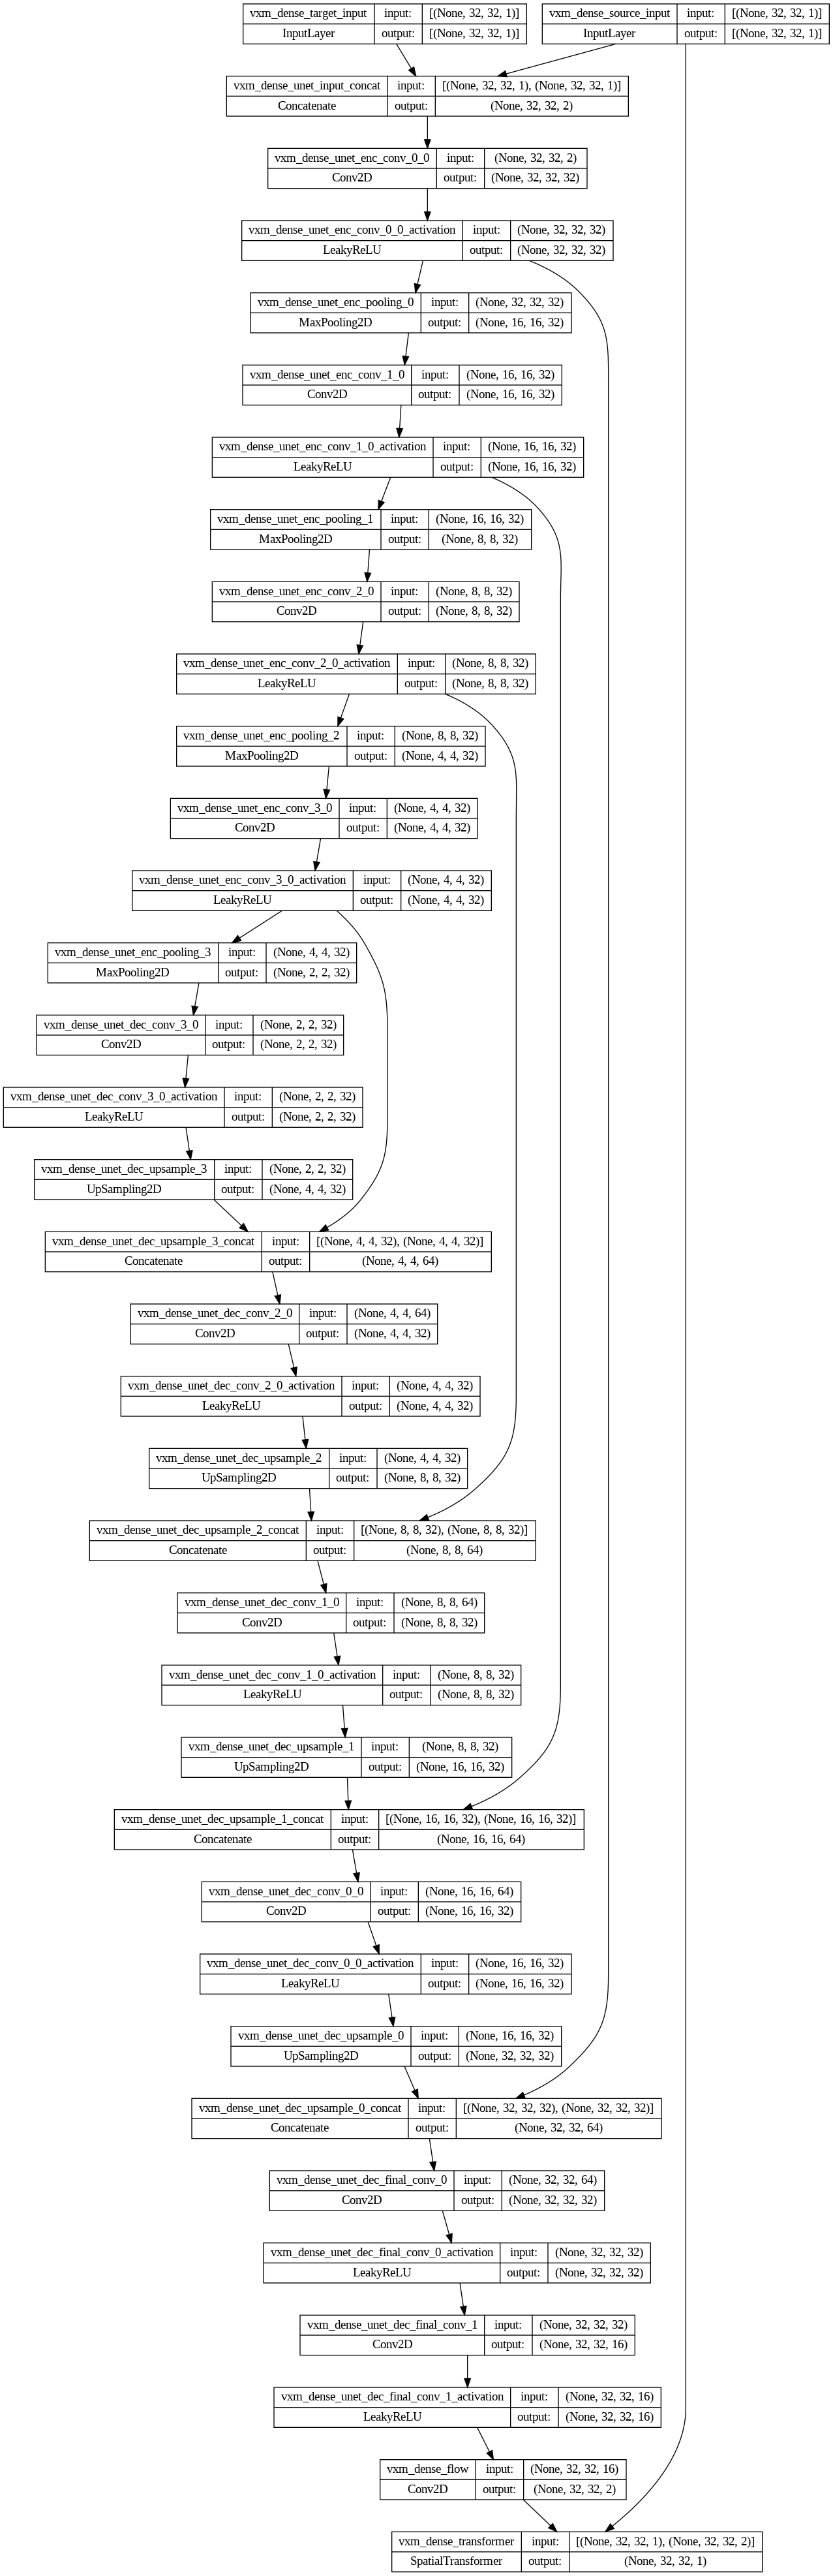

In [84]:
# configure unet input shape (concatenation of moving and fixed images)
ndim = 2
unet_input_features = 2
inshape = (*x_train.shape[1:], unet_input_features)

# configure unet features
nb_features = [
    [32, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16]  # decoder features
]

# build model using VxmDense
inshape = x_train.shape[1:]
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

# voxelmorph has a variety of custom loss classes
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter
lambda_param = 0.05
loss_weights = [1, lambda_param]

vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

tf.keras.utils.plot_model(vxm_model, to_file='model.png', show_shapes=True)

2 (32, 32, 32, 1)


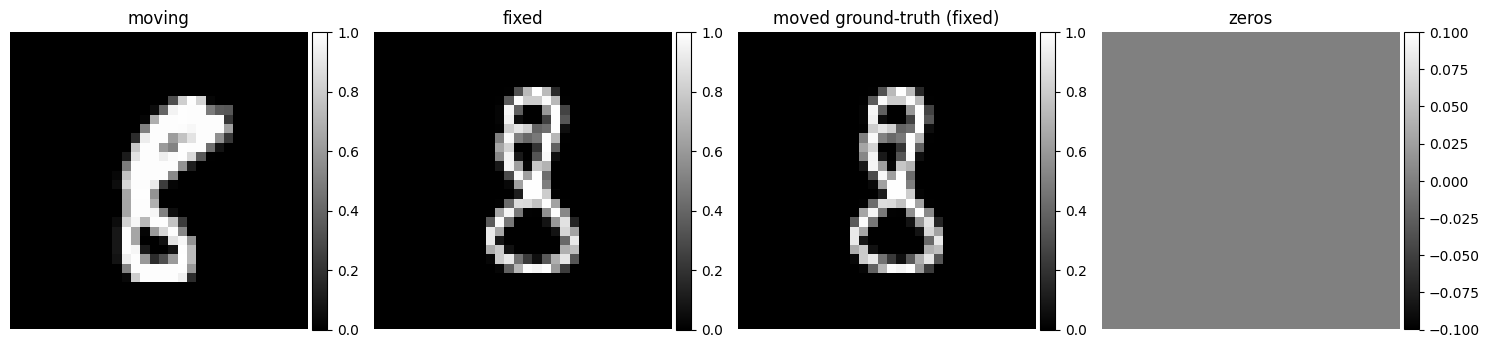

In [86]:
def plot_history(hist, loss_name='loss'):
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss', size=20)
    plt.xlabel('epoch', size=20)
    plt.grid()
    plt.show()
    
def vxm_data_generator(x_data, batch_size=32):   

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)

    # prepare a zero array the size of the deformation
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])

    while True:
        # prepare inputs: images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]

        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare the resulting moved image with the fixed image.
        # we also wish to penalize the deformation field.
        outputs = [fixed_images, zero_phi]

        yield (inputs, outputs)

# let's test it
train_generator = vxm_data_generator(x_train)
in_sample, out_sample = next(train_generator)

print(len(in_sample), in_sample[0].shape)

# visualize
images = [img[0, :, :, 0] for img in in_sample + out_sample]
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

Now, let's train the model for $10$ epochs, using the following code snippet.

In [90]:
nb_epochs = 10
steps_per_epoch = 100
hist = vxm_model.fit(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2);

Epoch 1/10
1/1 [==============================] - 0s 321ms/step
100/100 - 19s - loss: 0.0530 - vxm_dense_transformer_loss: 0.0506 - vxm_dense_flow_loss: 0.0481 - 19s/epoch - 194ms/step
Epoch 2/10
1/1 [==============================] - 0s 31ms/step
100/100 - 14s - loss: 0.0234 - vxm_dense_transformer_loss: 0.0187 - vxm_dense_flow_loss: 0.0954 - 14s/epoch - 137ms/step
Epoch 3/10
1/1 [==============================] - 0s 29ms/step
100/100 - 14s - loss: 0.0191 - vxm_dense_transformer_loss: 0.0144 - vxm_dense_flow_loss: 0.0941 - 14s/epoch - 135ms/step
Epoch 4/10
1/1 [==============================] - 0s 29ms/step
100/100 - 13s - loss: 0.0175 - vxm_dense_transformer_loss: 0.0128 - vxm_dense_flow_loss: 0.0940 - 13s/epoch - 128ms/step
Epoch 5/10
1/1 [==============================] - 0s 32ms/step
100/100 - 14s - loss: 0.0159 - vxm_dense_transformer_loss: 0.0113 - vxm_dense_flow_loss: 0.0924 - 14s/epoch - 137ms/step
Epoch 6/10
1/1 [==============================] - 0s 31ms/step
100/100 - 14s - 

In [ ]:
val_generator = vxm_data_generator(x_val, batch_size = 1)
val_input, _ = next(val_generator)
val_pred = vxm_model.predict(val_input)
# visualize
images = [img[0, :, :, 0] for img in val_input + val_pred] + \
         [np.dstack((val_input[0][0,:,:,0], val_input[1][0,:,:,0], val_input[0][0,:,:,0]/2 + val_input[1][0,:,:,0]/2))] + \
         [np.dstack((val_input[1][0,:,:,0], val_pred[0][0,:,:,0], val_input[1][0,:,:,0]/2 + val_pred[0][0,:,:,0]/2))]
titles = ['moving', 'fixed', 'moved', 'flow', 'before reg', 'after reg']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True, show=False);
ne.plot.flow([val_pred[1].squeeze()], width=5, show=False);

![](images/deepreg_out.png)

## Questions

1. Rotation invariance of **ORB** feature: Show that the ORB feature is rotation invariant. For example, take the following image of the Victoria memorial hall and its rotated version as input images. Choose a single ORB feature (e.g., the one on its fairy) detected in the original image (mark it red), show that the same feature is detected from the rotated image too. You shuld obtain a figure like the following one.

![](images/orb_rot_invar.png)

   Similarly, show that the feature is scale invariant too.


2. Finding **near-duplicate** images (upto rotation / scaling): Use **ORB** features to find near-duplicate images, for example from the following images of the Victoria memorial hall and Tajmahal. Notice that there are 2 unique images and all the other images are obtained by applying rotation / scaling / changing background.

![](images/vic_taj.png)

Extract ORB feature descriptiors (50 features, e.g.) and concat the features to obtain a single vector for each image. Now, use a nearest-neighbor algorithm (e.g., `ball_tree` from `sklearn.neighbors.NearestNeighbors`) to find the nearest descriptors from the images and display the top `4` (e.g., `k=4`) **near-duplicate images** found, as shown in the next figure. As can be seen, querying with a Victoria image (descriptor vector) fetches all the images obtained with rotation / scaling / changing the background of the original image (also report the NN-distances obtained).

![](images/orb_search.png) 

## References

1. https://stackoverflow.com/questions/41692063/what-is-the-difference-between-image-registration-and-image-alignment
2. https://cs.brown.edu/courses/cs129/2012/asgn/proj1/
3. https://www.loc.gov/pictures/search/?q=Prokudin+negative&sp=3&st=grid
4. https://github.com/SuperElastix/elastix/releases/tag/5.1.0
5. https://in.mathworks.com/help/images/ref/imregdemons.html
6. https://www.cs.cmu.edu/~galeotti/methods_course/ITK_Registration.pdf
7. http://matthewalunbrown.com/papers/ijcv2007.pdf
8. https://pyimagesearch.com/2018/12/17/image-stitching-with-opencv-and-python/
9. https://youtu.be/TDmrzvtpwOM